# Deepweeds - MobileNetv3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

tf.__version__

2025-06-29 01:41:40.898160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 01:41:40.898281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 01:41:41.026448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

# Configurations

In [2]:
INFERENCE_DEVICE = 'GPU:0' if len(tf.config.list_physical_devices('GPU')) else 'CPU:0'

################################
###### Configurations #########
##############################
seed = 999
SEED = seed
USE_DETERMINISTIC = True
K_FOLD_INDEX = 4
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME=f"MobileNetV3Small_KF{K_FOLD_INDEX+1}.keras"
IMG_SIZE=(224,224,3)

## Training Configurations
TRAIN_BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 16 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-7 ## Minimum Learning Rate for ReduceLROnPlateau Callback
##
USE_WARMUP = False
WARMUP_EPOCHS = 5
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCHS
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.3

##### Base Model Freezing Part
INIT_LR2 = 2e-6 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-4 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau

#### -- Optimizer
USE_ADAMW = '2.15' in tf.__version__
#########################################
isKaggle = 'kaggle' in os.getcwd()

if isKaggle:
    DATASET_PATH = "/kaggle/input/deepweeds"
    IMAGE_DATASET_PATH = "/kaggle/input/deepweeds/images" ## For Kaggle
    DATASET_OUTPUT_PATH = "/kaggle/working/deepweeds_9c" ## For Kaggle
else:
    try:
        DATASET_PATH = reganmaharjan_deepweeds_path
        DATASET_OUTPUT_PATH = '/content/dataset_9c' ## For GoogleColab
        IMAGE_DATASET_PATH = reganmaharjan_deepweeds_path + '/images' ## For GoogleColab
    except:
        DATASET_PATH = ''
        IMAGE_DATASET_PATH = '' ## Assign The Image Path
        DATASET_OUTPUT_PATH = '' ## Assign The path where the Images are to ogranized for Data Generator from Directory


isTPU = False
fixDatasetBatch = False ## if True: duplicates files randomly such that each batch contains same no.of files - Required when isTPU=True.

In [3]:
print("Tensorflow version " + tf.__version__)
if tf.config.list_logical_devices('TPU'):
    if isKaggle:
        # On TPU VMs use this line instead:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  ## if kaggle
    else:        
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver() ## if colab

    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    #---------
    strategy = tf.distribute.TPUStrategy(resolver)
    print('TPU available')
    isTPU = True
else: ### If GPU or CPU
    if tf.config.list_logical_devices('GPU'): 
        print('GPU available')
    else:
        print("Only CPU available")
       
    # For testing without a TPU use this line instead: 
    # strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    strategy = tf.distribute.MirroredStrategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)
if isTPU:
    USE_ADAMW = False
    LR_REDUCTION_PATIENCE = 5
    ES_PATIENCE = 27
    print("Use ADAM with TPU")

Tensorflow version 2.15.0
GPU available
REPLICAS:  1


In [4]:
def seedEverything(seed=42, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    tf.keras.utils.set_random_seed(seed)
    
    if deterministic:
        tf.config.experimental.enable_op_determinism()
        
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED, USE_DETERMINISTIC)
tf.config.set_soft_device_placement(True)

In [5]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [6]:
try:
    data_info = pd.read_csv(f"{DATASET_PATH}/labels.csv") ## For Kaggle
except:
    data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [7]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [8]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [9]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 5 out of 5 folds
-------------------------------------------------



In [11]:
## Using Folds Used in The DeepWeeds Paper
try:
    train_data = pd.read_csv(f'{DATASET_PATH}/train_subset{K_FOLD_INDEX}.csv')
    valid_data = pd.read_csv(f'{DATASET_PATH}/val_subset{K_FOLD_INDEX}.csv')
    test_data = pd.read_csv(f'{DATASET_PATH}/test_subset{K_FOLD_INDEX}.csv')

except:
    train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
    valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
    test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab

train_data.rename(columns={"Label":"label"}, inplace=True)
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  606  645  610  5464 	Total: (10508, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  205  213  202  215  203  1821 	Total: (3503, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  204  212  201  214  203  1821 	Total: (3498, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0, oversampling_labels=[]):
    indices=[]
    if fixDatasetBatch or isTPU:
        batch = TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync
        size = data_info.shape[0]
        remainder = size % batch
        residue = batch - remainder
        rng = np.arange(size)
        np.random.shuffle(rng)
        indices = rng[:residue]
        
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)
            elif index in indices:
                sample_filename = os.path.join(target_path, f"last_batch_fix_{index}-"+filename)
                shutil.copy(source, sample_filename)
                
            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import math

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.0 if math.isnan(v) else v for v in history['accuracy']]
    val_acc = [0.0 if math.isnan(v) else v for v in history['val_accuracy']]
    loss = [0.0 if math.isnan(v) else v for v in history['loss']]
    val_loss = [0.0 if math.isnan(v) else v for v in history['val_loss']]
    
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [14]:
if oversampling:
    print("Oversampling training set",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

input_dir = IMAGE_DATASET_PATH
base_dir = DATASET_OUTPUT_PATH

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

with strategy.scope(): 
    if isTPU:  
        train_generator = train_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        validation_generator = validation_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        test_generator = test_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        
    train_generator = train_generator.prefetch(tf.data.AUTOTUNE)
    validation_generator = validation_generator.prefetch(tf.data.AUTOTUNE)
    test_generator = test_generator.prefetch(tf.data.AUTOTUNE)     

Found 10508 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.
Found 3498 files belonging to 9 classes.


# Sample Images

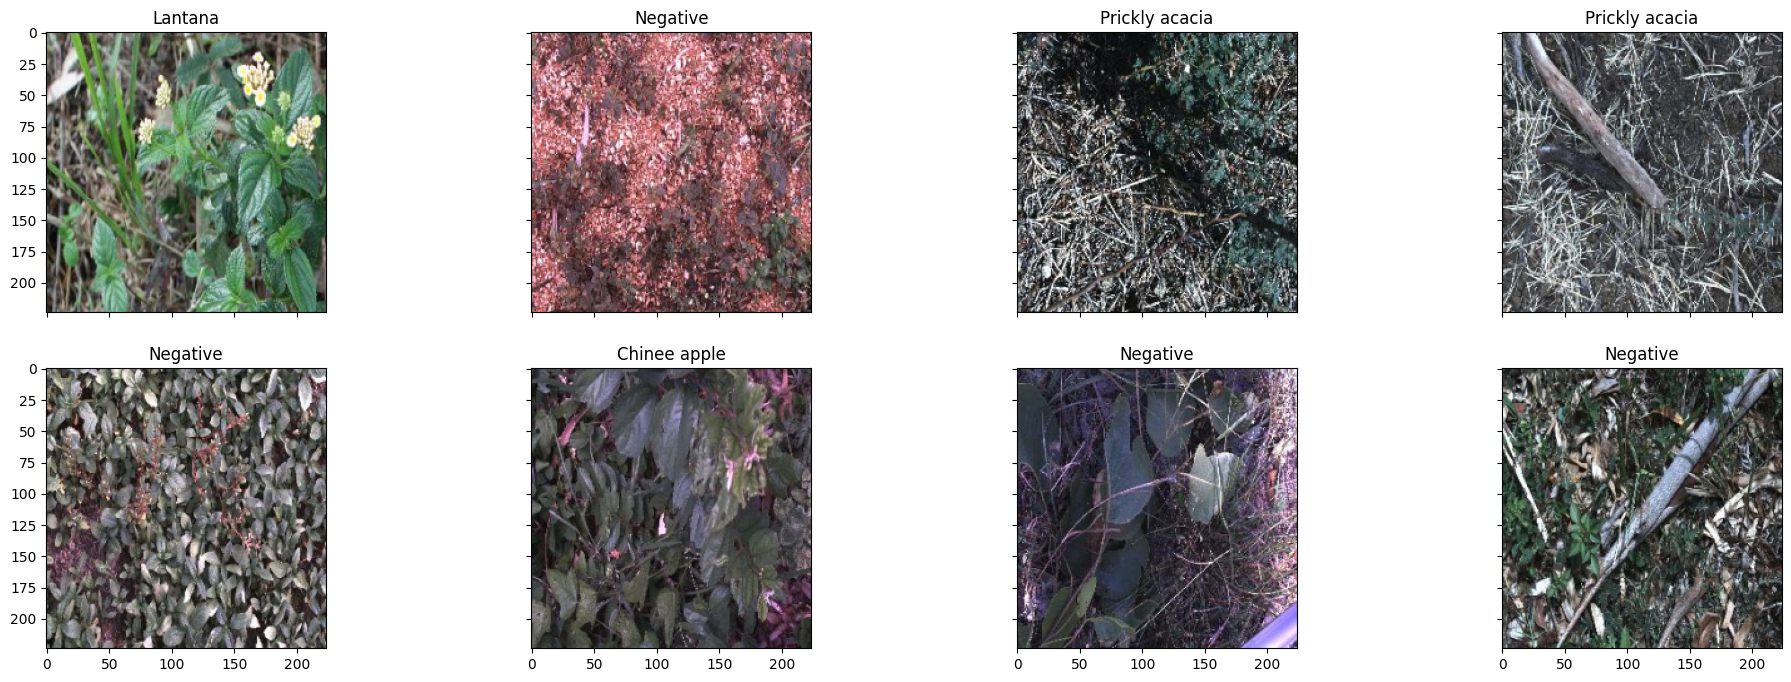

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    augs = [] if isTPU else [layers.RandomRotation(0.5, seed=seed, name='RR_Rot'), 
                            layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
                            layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),] ## can't run with TPU
    
    aug_model = keras.Sequential([
        layers.Input(IMG_SIZE),
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        *augs,
        layers.GaussianNoise(0.01, seed=SEED, name='RR_GNoise'),
        # layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')
    aug_model.summary()
    
    return aug_model


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('conv' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    FCLayer = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-FCLayer")
    
    return base_model , FCLayer

def buildModel(IMG_SIZE, fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, FCLayer = MobilenetV3Base(IMG_SIZE)
    base_model.trainable = True
    FCLayer.trainable = True
    FCLayer.summary()
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.3, seed=SEED)(x) 
    
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = FCLayer(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
with strategy.scope():
    model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Model: "MobileNet-FCLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 576)]       0         
                                                                 
 Conv_2 (Conv2D)             (None, 1, 1, 1024)        590848    
                                                                 
Total params: 590848 (2.25 MB)
Trainable params: 590848 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Base Model: MobilenetV3small_base_
228
Model: "augment_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RR_Bright (RandomBrightnes  (None, 224, 224, 3)       0         
 s)                                                              
               

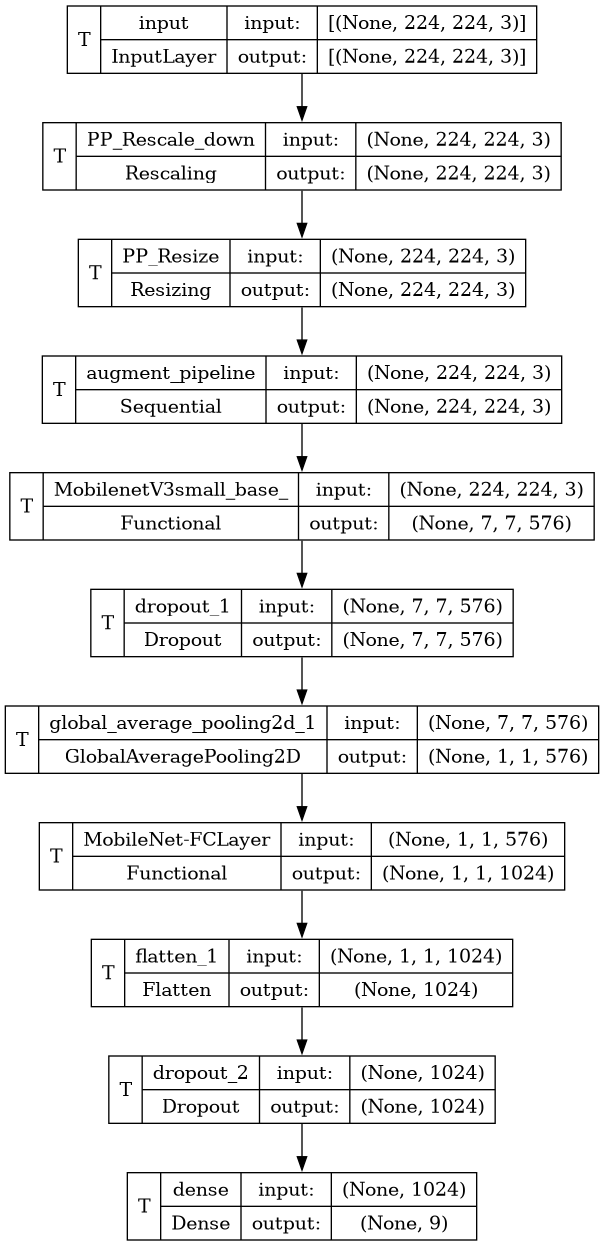

In [20]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import Adam, AdamW

checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor=ES_MONITOR)
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1, clipnorm=1.0) if not USE_ADAMW else AdamW(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

    def createWarmUpScheduler(epochs=5, inc_rate=0.5, init_lr=2e-6, final_lr=2e-5):
        def scheduler(e, lr):
            if e < epochs:
                new_lr =  lr + (lr * inc_rate)
                return new_lr if new_lr < final_lr else final_lr
            elif e == epochs:
                return final_lr
            else:
                return lr

        return scheduler
        
    warmup = keras.callbacks.LearningRateScheduler(createWarmUpScheduler(WARMUP_EPOCHS, WARMUP_INCREMENT_RATE, WARMUP_INIT_LR, INIT_LR1))

    callbacks = [checkpoint, early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])
    print(len(callbacks))

print(model.optimizer.get_config())

3
{'name': 'AdamW', 'weight_decay': 0.05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0002, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-29 01:44:21.921759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751161468.110860      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 59s 85ms/step - loss: 0.2502 - accuracy: 0.5415 - val_loss: 0.1193 - val_accuracy: 0.7134 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 24s 73ms/step - loss: 0.1467 - accuracy: 0.6594 - val_loss: 0.0854 - val_accuracy: 0.7742 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 24s 73ms/step - loss: 0.1128 - accuracy: 0.7174 - val_loss: 0.0700 - val_accuracy: 0.8184 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 25s 74ms/step - loss: 0.0963 - accuracy: 0.7508 - val_loss: 0.0618 - val_accuracy: 0.8347 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 24s 73ms/step - loss: 0.0877 - accuracy: 0.7785 - val_loss: 0.0571 - val_accuracy: 0.8430 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 24s 73ms/step - loss: 0.0773 - accuracy: 0.7913 - val_loss: 0.0521 - val_accuracy: 0.8550 - lr: 2.0000e-04
Epoch 7/300
329/329 [===================

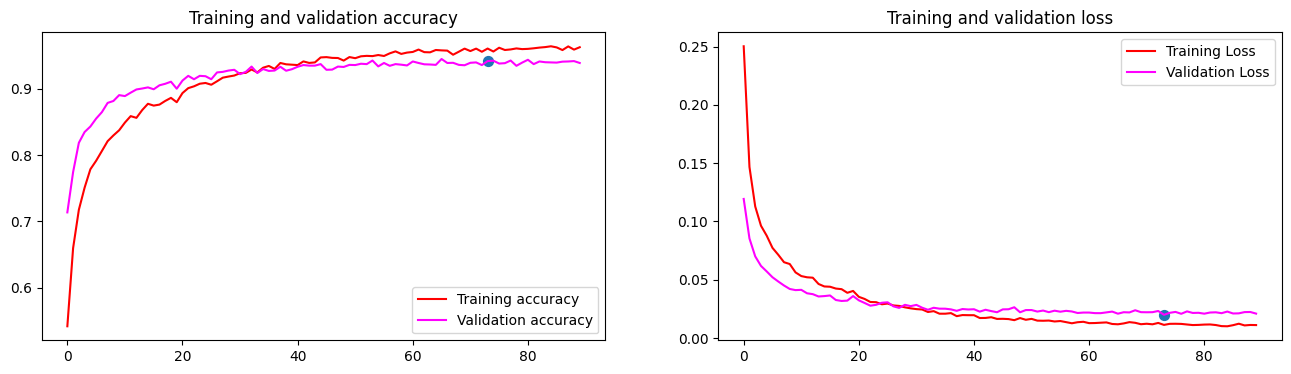

CPU times: user 1h 12min 32s, sys: 5min 33s, total: 1h 18min 5s
Wall time: 35min 56s


In [22]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 23ms/step - loss: 0.0034 - accuracy: 0.9868
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.97063   0.97781   0.97421       676
       Lantana    0.98891   0.97806   0.98345       638
   Parkinsonia    0.98555   0.99192   0.98873       619
    Parthenium    0.98371   0.98532   0.98452       613
Prickly acacia    0.98722   0.97017   0.97862       637
   Rubber vine    0.98845   0.98845   0.98845       606
     Siam weed    0.99067   0.98760   0.98913       645
    Snake weed    0.96569   0.96885   0.96727       610
      Negative    0.99050   0.99195   0.99122      5464

      accuracy                        0.98668     10508
     macro avg    0.98348   0.98224   0.98284     10508
  weighted avg    0.98669   0.98668   0.98667     10508


                False Positive Rate  Accuracy
Chinee apple               0.002034  0.977811
Lantana                    0.000709  0.978056
Parkinsonia                0.000910  0.991922
Parthenium                 0.001011  0.985318
Prickly acacia    

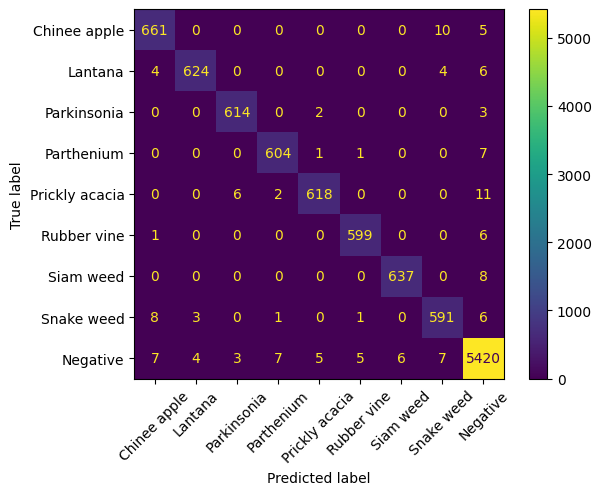


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.0233 - accuracy: 0.9361
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83036   0.82667   0.82851       225
       Lantana    0.92344   0.90610   0.91469       213
   Parkinsonia    0.97087   0.97087   0.97087       206
    Parthenium    0.98000   0.95610   0.96790       205
Prickly acacia    0.91667   0.92958   0.92308       213
   Rubber vine    0.95855   0.91584   0.93671       202
     Siam weed    0.93750   0.90698   0.92199       215
    Snake weed    0.89418   0.83251   0.86224       203
      Negative    0.94833   0.96760   0.95787      1821

      accuracy                        0.93748      3503
     macro avg    0.92888   0.91247   0.92043      3503
  weighted avg    0.93728   0.93748   0.93721      3503


                False Positive Rate  Accuracy
Chinee apple               0.011592  0.826667
Lantana                    0.004863  0.906103
Parkinsonia                0.001820  0.970874
Parthenium                 0.001213  0.956098
Prickly acacia    

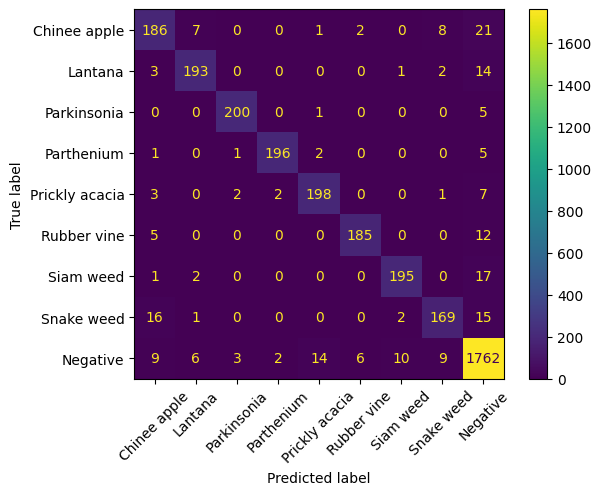


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 26ms/step - loss: 0.5142 - accuracy: 0.5094
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.16783   0.10667   0.13043       225
       Lantana    0.38710   0.11321   0.17518       212
   Parkinsonia    0.43750   0.06796   0.11765       206
    Parthenium    0.22000   0.05392   0.08661       204
Prickly acacia    0.36364   0.05660   0.09796       212
   Rubber vine    0.27660   0.06468   0.10484       201
     Siam weed    0.27660   0.06075   0.09962       214
    Snake weed    0.25532   0.05911   0.09600       203
      Negative    0.54626   0.91104   0.68300      1821

      accuracy                        0.50943      3498
     macro avg    0.32565   0.16599   0.17681      3498
  weighted avg    0.42690   0.50943   0.41017      3498


                False Positive Rate  Accuracy
Chinee apple               0.036358  0.106667
Lantana                    0.011564  0.113208
Parkinsonia                0.005468  0.067961
Parthenium                 0.011840  0.053922
Prickly acacia    

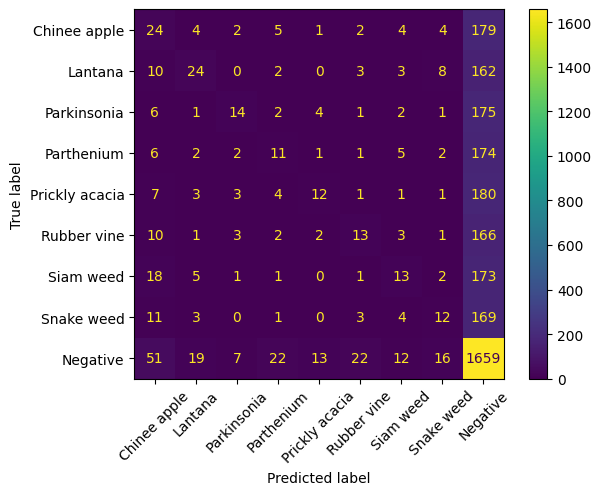

In [23]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Freezing Base Model

In [24]:
with strategy.scope():
    for layer in model.layers:
        if 'base' in layer.name.lower():
            print("Freezing layer", layer.name, layer.trainable)
            layer.trainable = False

Freezing layer MobilenetV3small_base_ True


# Evaluations #1.1b

Test After Freezing
Validation Set Stats
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0240 - accuracy: 0.9395
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87383   0.83111   0.85194       225
       Lantana    0.94608   0.90610   0.92566       213
   Parkinsonia    0.97129   0.98544   0.97831       206
    Parthenium    0.94340   0.97561   0.95923       205
Prickly acacia    0.93548   0.95305   0.94419       213
   Rubber vine    0.95000   0.94059   0.94527       202
     Siam weed    0.96552   0.91163   0.93780       215
    Snake weed    0.89529   0.84236   0.86802       203
      Negative    0.95845   0.97529   0.96679      1821

      accuracy                        0.94747      3503
     macro avg    0.93770   0.92458   0.93080      3503
  weighted avg    0.94702   0.94747   0.94703      3503


                False Positive Rate  Accuracy
Chinee apple               0.008237  0.831111
Lantana                    0.003343  0.906103
Parkinsonia                0.001820  0.985437
Parthenium                 0.003639  0.975610
Prickly acacia    

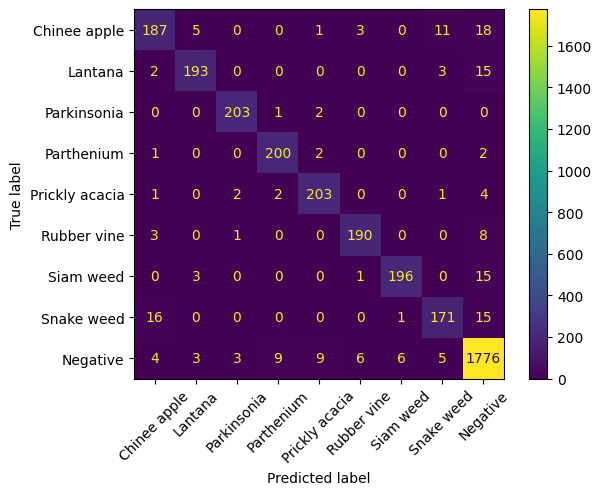

Test Set Stats
model.evaluate
110/110 [==============================] - 3s 26ms/step - loss: 0.5142 - accuracy: 0.5094
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93000   0.82667   0.87529       225
       Lantana    0.97970   0.91038   0.94377       212
   Parkinsonia    0.97573   0.97573   0.97573       206
    Parthenium    0.98469   0.94608   0.96500       204
Prickly acacia    0.94203   0.91981   0.93079       212
   Rubber vine    0.94175   0.96517   0.95332       201
     Siam weed    0.95694   0.93458   0.94563       214
    Snake weed    0.90640   0.90640   0.90640       203
      Negative    0.95518   0.98298   0.96888      1821

      accuracy                        0.95369      3498
     macro avg    0.95249   0.92976   0.94053      3498
  weighted avg    0.95368   0.95369   0.95326      3498


                False Positive Rate  Accuracy
Chinee apple               0.004277  0.826667
Lantana                    0.001217  0.910377
Parkinsonia                0.001519  0.975728
Parthenium                 0.000911  0.946078
Prickly acacia    

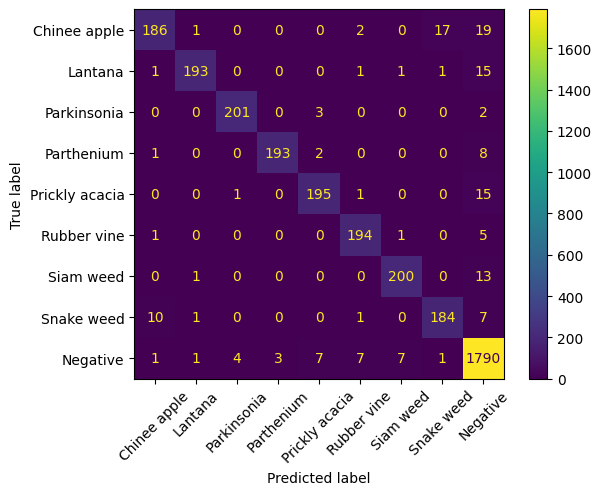

In [25]:
## Test After Freezing
print("Test After Freezing")
print("Validation Set Stats")        
a, b = eval_model(model, validation_generator)

print("Test Set Stats")   
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.86607   0.86222   0.86414       225
       Lantana    0.87879   0.95755   0.91648       212
   Parkinsonia    0.97573   0.97573   0.97573       206
    Parthenium    0.98469   0.94608   0.96500       204
Prickly acacia    0.86975   0.97642   0.92000       212
   Rubber vine    0.94146   0.96020   0.95074       201
     Siam weed    0.95238   0.93458   0.94340       214
    Snake weed    0.90640   0.90640   0.90640       203
      Negative    0.97087   0.95167   0.96118      1821

      accuracy                        0.94568      3498
     macro avg    0.92735   0.94121   0.93367      3498
  weighted avg    0.94695   0.94568   0.94594      3498


                False Positive Rate  Accuracy
Chinee apple               0.009166  0.862222
Lantana                    0.008521  0.957547
Parkinsonia                0.001519  0.975728
Parthenium                 0.000911  0.946078
Prickly acacia    

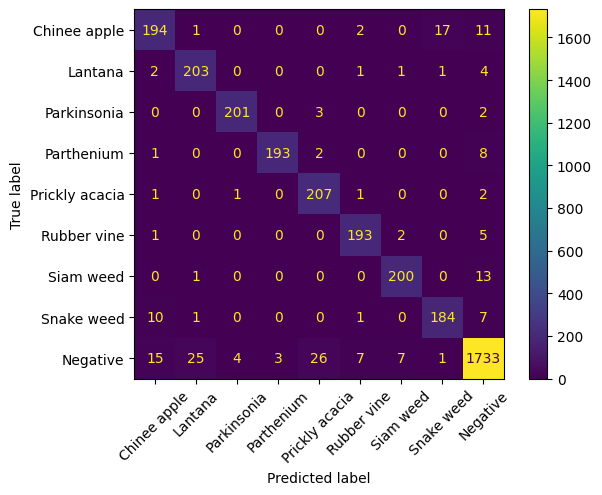

In [26]:
printStats(a,b,0.11)

# Trial 2

In [27]:
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=INIT_LR2,  weight_decay=W_DECAY2, clipnorm=2.0) if not USE_ADAMW else AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=ES_MONITOR, factor=LR_REDUCTION_FACTOR, patience=ES_PATIENCE, verbose=1, min_lr=MIN_LR2)


print(model.optimizer.get_config())

{'name': 'AdamW', 'weight_decay': 0.0005, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 2e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-29 02:24:49.585032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 17s 38ms/step - loss: 0.0295 - accuracy: 0.9079 - val_loss: 0.0190 - val_accuracy: 0.9469 - lr: 2.0000e-06
Epoch 2/300
329/329 [==============================] - 11s 34ms/step - loss: 0.0285 - accuracy: 0.9104 - val_loss: 0.0188 - val_accuracy: 0.9475 - lr: 2.0000e-06
Epoch 3/300
329/329 [==============================] - 12s 37ms/step - loss: 0.0279 - accuracy: 0.9137 - val_loss: 0.0187 - val_accuracy: 0.9469 - lr: 2.0000e-06
Epoch 4/300
329/329 [==============================] - 11s 34ms/step - loss: 0.0265 - accuracy: 0.9144 - val_loss: 0.0188 - val_accuracy: 0.9460 - lr: 2.0000e-06
Epoch 5/300
329/329 [==============================] - 11s 33ms/step - loss: 0.0259 - accuracy: 0.9191 - val_loss: 0.0188 - val_accuracy: 0.9466 - lr: 2.0000e-06
Epoch 6/300
329/329 [==============================] - 12s 36ms/step - loss: 0.0259 - accuracy: 0.9178 - val_loss: 0.0189 - val_accuracy: 0.9472 - lr: 2.0000e-06
Epoch 7/300
329/329 [===================

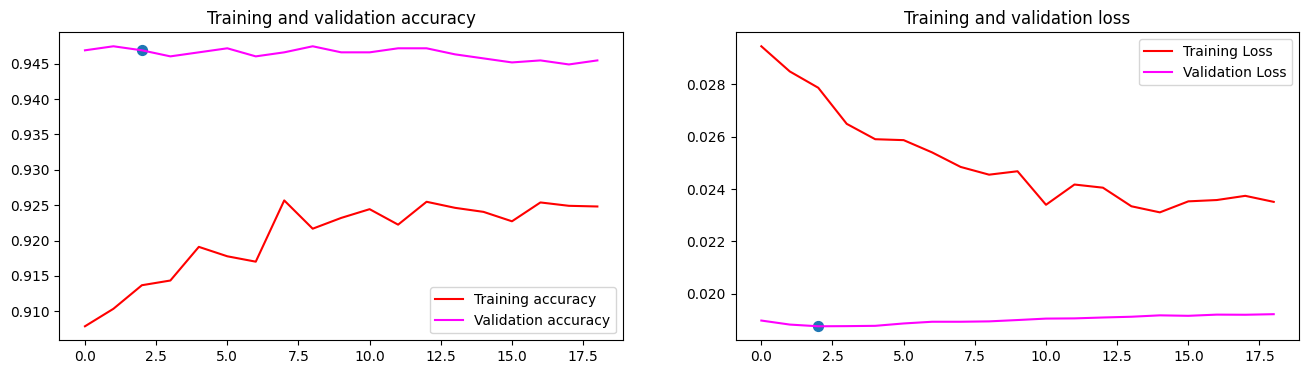

In [28]:
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Checkpoint")
model.save("2-"+MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)


# Accuracy / Loss Plots

Total Epochs: range(0, 109)


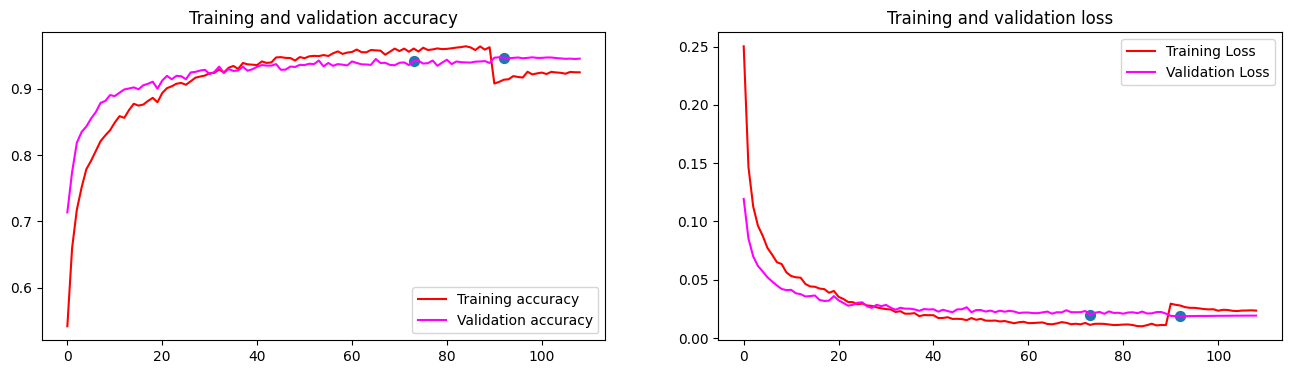

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 90)


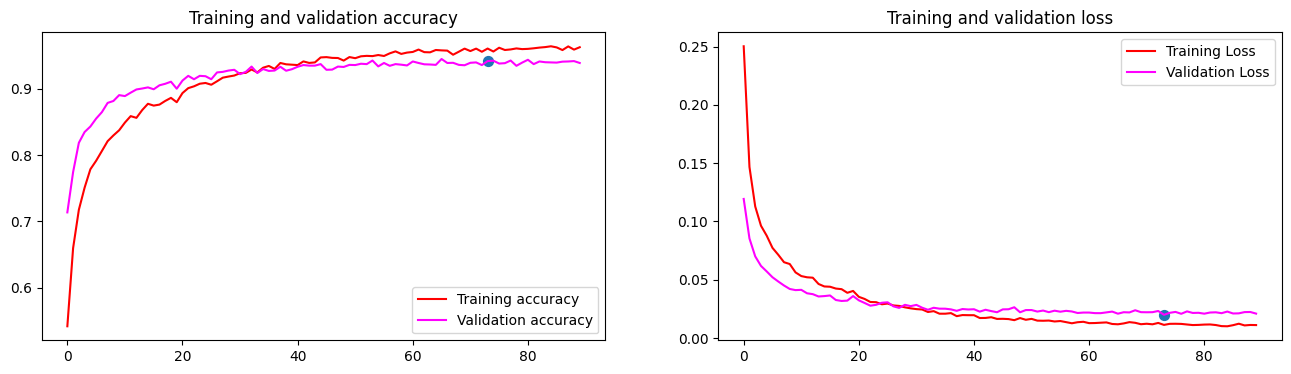

Total Epochs: range(0, 19)


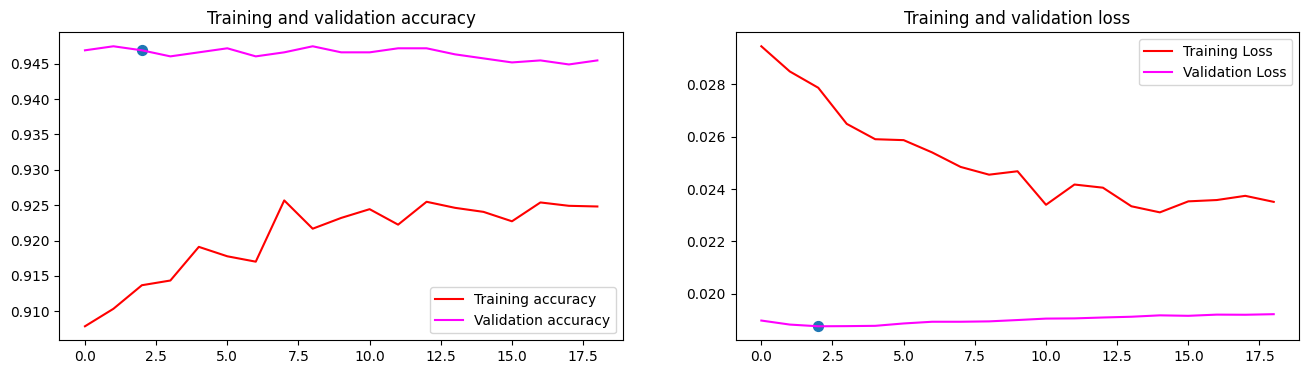

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 7s 20ms/step - loss: 0.0019 - accuracy: 0.9928
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99545   0.97041   0.98277       676
       Lantana    1.00000   0.98589   0.99290       638
   Parkinsonia    0.99197   0.99838   0.99517       619
    Parthenium    0.98548   0.99674   0.99108       613
Prickly acacia    0.99062   0.99529   0.99295       637
   Rubber vine    0.99018   0.99835   0.99425       606
     Siam weed    0.99227   0.99535   0.99381       645
    Snake weed    0.96950   0.99016   0.97972       610
      Negative    0.99578   0.99433   0.99505      5464

      accuracy                        0.99277     10508
     macro avg    0.99014   0.99166   0.99086     10508
  weighted avg    0.99282   0.99277   0.99277     10508


                False Positive Rate  Accuracy
Chinee apple               0.000305  0.970414
Lantana                    0.000000  0.985893
Parkinsonia                0.000506  0.998384
Parthenium                 0.000910  0.996737
Prickly acacia    

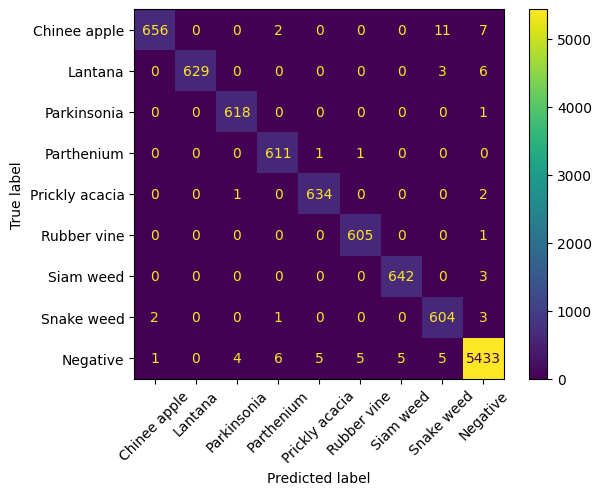


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 21ms/step - loss: 0.0187 - accuracy: 0.9469
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90500   0.80444   0.85176       225
       Lantana    0.95025   0.89671   0.92271       213
   Parkinsonia    0.97143   0.99029   0.98077       206
    Parthenium    0.95215   0.97073   0.96135       205
Prickly acacia    0.91928   0.96244   0.94037       213
   Rubber vine    0.93659   0.95050   0.94349       202
     Siam weed    0.94393   0.93953   0.94172       215
    Snake weed    0.85096   0.87192   0.86131       203
      Negative    0.96345   0.96980   0.96661      1821

      accuracy                        0.94690      3503
     macro avg    0.93256   0.92849   0.93001      3503
  weighted avg    0.94675   0.94690   0.94653      3503


                False Positive Rate  Accuracy
Chinee apple               0.005796  0.804444
Lantana                    0.003040  0.896714
Parkinsonia                0.001820  0.990291
Parthenium                 0.003032  0.970732
Prickly acacia    

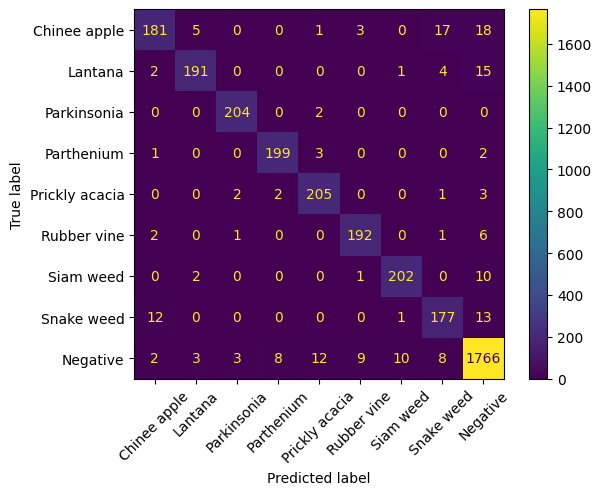


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.0176 - accuracy: 0.9545
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.94301   0.80889   0.87081       225
       Lantana    0.97487   0.91509   0.94404       212
   Parkinsonia    0.97573   0.97573   0.97573       206
    Parthenium    0.98974   0.94608   0.96742       204
Prickly acacia    0.93868   0.93868   0.93868       212
   Rubber vine    0.93301   0.97015   0.95122       201
     Siam weed    0.94419   0.94860   0.94639       214
    Snake weed    0.89048   0.92118   0.90557       203
      Negative    0.96019   0.98023   0.97011      1821

      accuracy                        0.95455      3498
     macro avg    0.94999   0.93385   0.94111      3498
  weighted avg    0.95473   0.95455   0.95413      3498


                False Positive Rate  Accuracy
Chinee apple               0.003361  0.808889
Lantana                    0.001522  0.915094
Parkinsonia                0.001519  0.975728
Parthenium                 0.000607  0.946078
Prickly acacia    

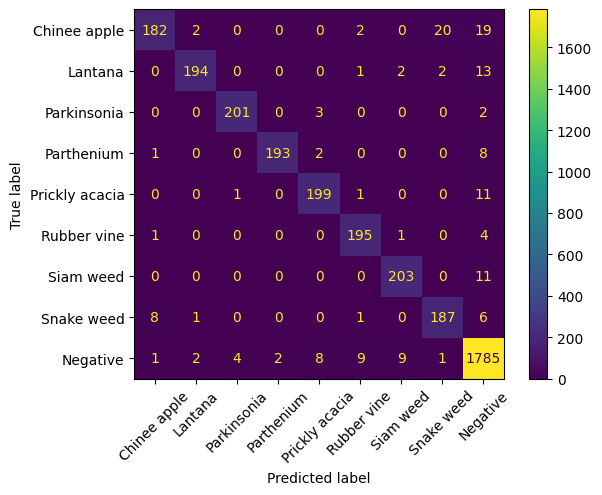

In [31]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87097   0.84000   0.85520       225
       Lantana    0.87826   0.95283   0.91403       212
   Parkinsonia    0.97573   0.97573   0.97573       206
    Parthenium    0.98974   0.94608   0.96742       204
Prickly acacia    0.85246   0.98113   0.91228       212
   Rubber vine    0.93269   0.96517   0.94866       201
     Siam weed    0.93548   0.94860   0.94200       214
    Snake weed    0.89048   0.92118   0.90557       203
      Negative    0.97290   0.94618   0.95935      1821

      accuracy                        0.94340      3498
     macro avg    0.92208   0.94188   0.93114      3498
  weighted avg    0.94507   0.94340   0.94369      3498


                False Positive Rate  Accuracy
Chinee apple               0.008555  0.840000
Lantana                    0.008521  0.952830
Parkinsonia                0.001519  0.975728
Parthenium                 0.000607  0.946078
Prickly acacia    

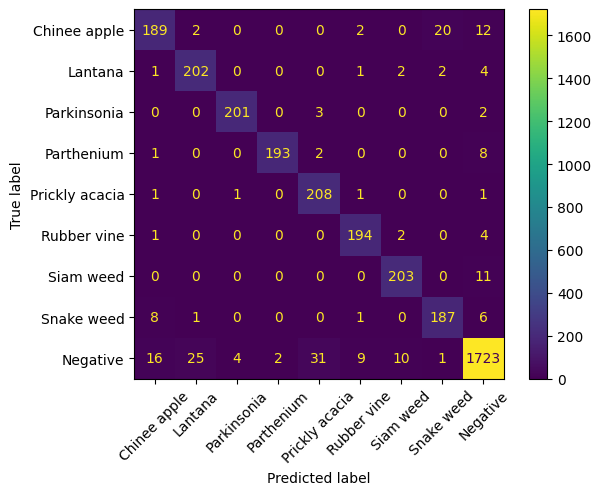

In [32]:
printStats(a,b,0.11)

## Clear Files

In [33]:
shutil.rmtree(base_dir)